## Bunny Studio
### Search Data Scientist Test Part I

Objective:

- Find samples(content) given a search pattern and make sure recommendations are as close as possible to the search pattern based not only on the sample metadata but also on it's creator's (pro) statistics in the platform.

<center>
<img src="images/cleaning.jpg" />
</center>


Workflow:

- Read and preprocess data
- Obtain embeddings from every sample attributes and tags
- Export embeddings 


In [1]:
##lets import some libraries to read and manipulate data

import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from unidecode import unidecode
from utils import *
from config import ATTRIBUTES_BY_CATEGORY,MODEL_NAME_HF,WEIGHTS_SCORE
from sklearn.preprocessing import MinMaxScaler

from sentence_transformers import SentenceTransformer

model = SentenceTransformer(MODEL_NAME_HF)



[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jhonp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\jhonp\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Read Data

In [22]:
pro_stats=pd.read_csv("input_data/pro_stats.csv")
sample_attributes=pd.read_csv("input_data/sample_attributes.csv")
sample_tags=pd.read_csv("input_data/sample_tags.csv")

print("[INFO] PRO_STATS shape: {}".format(pro_stats.shape))
print("[INFO] SAMPLE_ATTRIBUTES shape: {}".format(sample_attributes.shape))
print("[INFO] SAMPLE_TAGS shape: {}".format(sample_tags.shape))

[INFO] PRO_STATS shape: (108140, 10)
[INFO] SAMPLE_ATTRIBUTES shape: (632084, 6)
[INFO] SAMPLE_TAGS shape: (293603, 4)


### Exploring Sample Attributes by category

As sample attributes may have multiple names, we must find which ones could be filtered out in order to trim every sample final description. In the following cell we check the distribution of attribute names by category, keeping only the ones that have more than 0.1% of the data by category. As we can see in the figure below,there are a lot of attribute names, from which we could get information for every sample. However, as using every attribute to find similarities between a search pattern and a sample could increase response latency significantly, we'll only keep top 3 attribute names for every category.

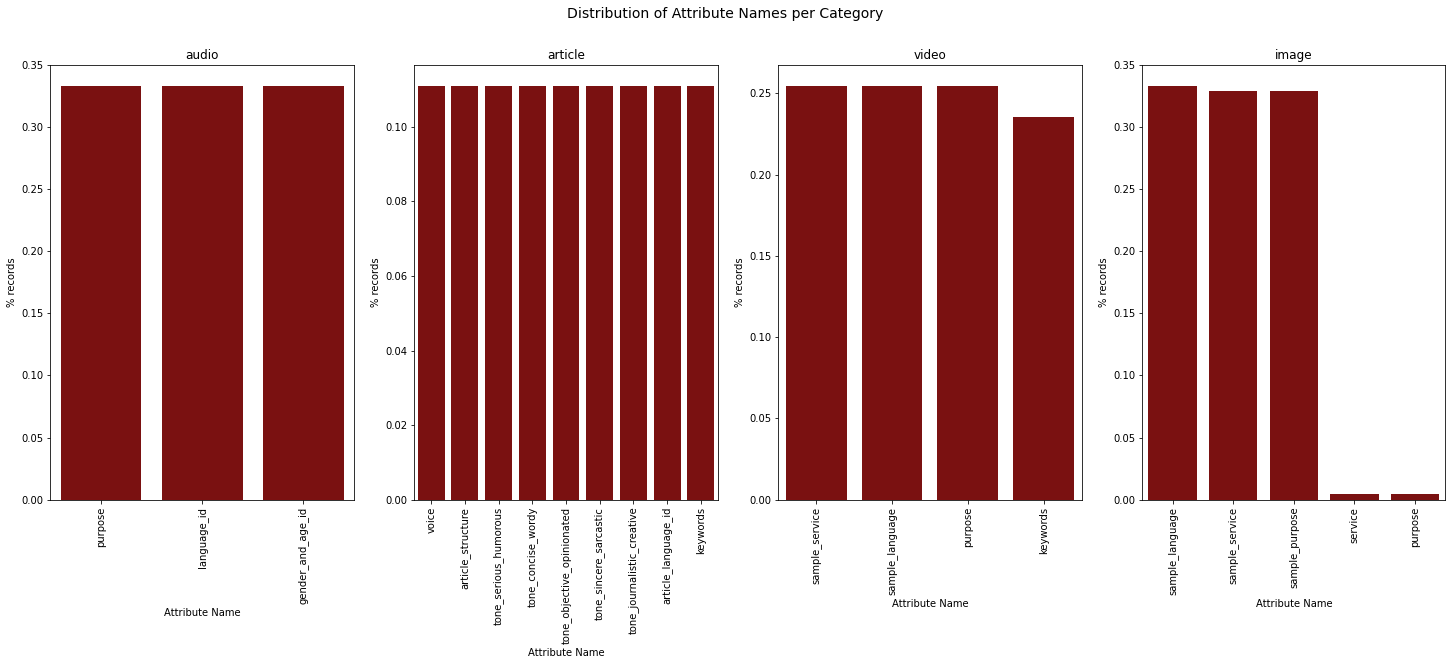

In [3]:
##make descriptive plot to show how every feature per category was selected
categories=sample_attributes.category.unique().tolist()
def get_attributes(df,category: str):
    str_query=f'category=="{category}"'
    return df.query(str_query).attribute_name.value_counts(True).reset_index().query("attribute_name>0.001")


fig=plt.figure(figsize=(25,8))

for i in range(4):
    datac=get_attributes(sample_attributes,category=categories[i])
    ax=fig.add_subplot(1,4,i+1)
    sns.barplot(x="index",y="attribute_name",data=datac,color="darkred",ax=ax)
    ax.set_ylabel("% records")
    ax.set_xlabel("Attribute Name")
    ax.set_title(categories[i])
    plt.xticks(rotation=90);
fig.suptitle("Distribution of Attribute Names per Category",size=14);



### Article samples: Numerical Attributes
- samples that come from the article category seem to have numerical attributes, for that reason we will assume the category as a value when the attribute value is greater than 0

In [4]:
##fill null values with an empty string
sample_attributes.fillna("",inplace=True) 
sample_attributes.loc[:,'if_article_specs']=sample_attributes.apply(lambda k: k['attribute_name'].split("_")[-1] if k['attribute_name'] in ['tone_serious_humorous','tone_sincere_sarcastic','tone_journalistic_creative'] and to_float(k['attribute_value'])>0 else "",axis=1)
sample_attributes.head()

,sample_id,category,pro_id,booking_score,attribute_name,attribute_value,if_article_specs
0,7,audio,D6,0.0,purpose,phoneSystems,
1,7,audio,D6,0.0,language_id,eng-us,
2,7,audio,D6,0.0,gender_and_age_id,youngAdultFemale,
3,21,audio,2362,0.0,purpose,phoneSystems,
4,21,audio,2362,0.0,language_id,eng-us,


In [5]:
##select only top 3 attribute names by category, check config.py file for details
rows_to_keep=sample_attributes.apply(lambda k: True if k['attribute_name'] in ATTRIBUTES_BY_CATEGORY[k['category']] else False, axis=1)
## new sample_attributes file
sample_attributes=sample_attributes.loc[rows_to_keep,:]
#modify attributes value to be more specific
sample_attributes.loc[:,'attribute_value']=sample_attributes.apply(lambda d: clean_sentence(str(d['attribute_value'])) if "language" not in d['attribute_name'] else decode_language_code(str(d['attribute_value'])),axis=1)

In [6]:
#concatenate attribute_value in one single column
sample_attributes.loc[:,'attribute_value']=sample_attributes.attribute_value+""+sample_attributes.if_article_specs
sample_attributes=sample_attributes.groupby(['sample_id','category','pro_id'])['attribute_value'].agg(lambda d: " ".join(list(set(d)))).reset_index()
sample_attributes.head()

,sample_id,category,pro_id,attribute_value
0,7,audio,D6,english american young adult female phone system
1,21,audio,2362,english american young adult female phone system
2,26,audio,2362,product video english american middle age female
3,28,audio,2362,english american young adult female phone system
4,30,audio,CE5,radio tv ad middle age male english american


### Exploring Sample Tags

This dataset has informative hashtags for every sample, lets concatenate tags per sample_id and clean them as we did with attribute values

In [8]:
sample_descriptions=sample_tags.groupby(["sample_id","category"])["tag_name"].agg(lambda d: ",".join(list(set(d)))).reset_index()
sample_descriptions.loc[:,'tag_name']=sample_descriptions.tag_name.apply(lambda d: remove_multispaces(remove_special_characters(d.lower(),replacement=" ")))
sample_descriptions.head()

,sample_id,category,tag_name
0,324,audio,vibrant english us general american neutral ph...
1,350,audio,calm approachable educational
2,441,audio,english us general american approachable neutr...
3,499,audio,english us general american neutral authentic ...
4,964,audio,english us general american neutral instructor...


In [21]:
##In case a sample doesnt have tags, lets assume this field as an empty string
samples_composed_data=sample_attributes.merge(sample_descriptions,on=['sample_id','category'],how="left")
samples_composed_data.tag_name.fillna(" ",inplace=True)
samples_composed_data.loc[:,'no_tag']=samples_composed_data.tag_name.apply(lambda k: 1 if k==" " else 0 )

print("[INFO] SAMPLE_COMPOSED_DATA shape: {}".format(samples_composed_data.shape))
print("[INFO] about {:.2%} of samples do not have any tags".format(samples_composed_data.no_tag.sum()/samples_composed_data.shape[0])  )
samples_composed_data.head()

[INFO] SAMPLE_COMPOSED_DATA shape: (205301, 6)
[INFO] about 68.14% of samples do not have any tags


,sample_id,category,pro_id,attribute_value,tag_name,no_tag
0,7,audio,D6,english american young adult female phone system,,1
1,21,audio,2362,english american young adult female phone system,,1
2,26,audio,2362,product video english american middle age female,,1
3,28,audio,2362,english american young adult female phone system,,1
4,30,audio,CE5,radio tv ad middle age male english american,,1


In [23]:
##compute embeddings for both attributes and tags
samples_composed_data.loc[:,'embeddings_attributes']=samples_composed_data.attribute_value.apply(lambda d: model.encode(d))
samples_composed_data.loc[:,'embeddings_tags']=samples_composed_data.apply(lambda k: model.encode(k['tag_name']) if k['no_tag']==0 else [0],axis=1)

In [28]:
##average embeddings (in case tag_name is empty, just use attribute embeddings)
samples_composed_data.loc[:,'avg_embeddings']=samples_composed_data.apply(lambda k: (k['embeddings_attributes']+k['embeddings_tags'])/2 if k['no_tag']==0 else k['embeddings_attributes'],axis=1)
samples_composed_data.head()

,sample_id,category,pro_id,attribute_value,tag_name,no_tag,embeddings_attributes,embeddings_tags,avg_embeddings
0,7,audio,D6,english american young adult female phone system,,1,"[-0.024831187, -0.018979557, -0.052266564, -0....",[0],"[-0.024831187, -0.018979557, -0.052266564, -0...."
1,21,audio,2362,english american young adult female phone system,,1,"[-0.024831187, -0.018979557, -0.052266564, -0....",[0],"[-0.024831187, -0.018979557, -0.052266564, -0...."
2,26,audio,2362,product video english american middle age female,,1,"[0.0061876783, 0.0027131322, -0.053051703, 0.0...",[0],"[0.0061876783, 0.0027131322, -0.053051703, 0.0..."
3,28,audio,2362,english american young adult female phone system,,1,"[-0.024831187, -0.018979557, -0.052266564, -0....",[0],"[-0.024831187, -0.018979557, -0.052266564, -0...."
4,30,audio,CE5,radio tv ad middle age male english american,,1,"[0.05209783, -0.0051229005, -0.06506547, -0.04...",[0],"[0.05209783, -0.0051229005, -0.06506547, -0.04..."


In [29]:
## Checkpoint: Save Embeddings to a file to unnecessarily processing datasets
samples_composed_data.drop(columns=['embeddings_attributes','embeddings_tags']).to_pickle("samples_composed_data.pkl")

### PRO's data:

Lets explore stats for every pro.

In [23]:
##Preprocess data

pro_stats.loc[:,'pro_id']=pro_stats.pro_id.astype(str)

##speed to book had an extreme value so we use a threshold for this feature, set it's quantile 99 for any value greater than that  (variable units were not provided)
quantile_99_speed_to_book=pro_stats.speed_to_book.quantile(0.99)
pro_stats.loc[:,'speed_to_book']=pro_stats.speed_to_book.apply(lambda d: quantile_99_speed_to_book if d>quantile_99_speed_to_book else d)

In [24]:
##percentage of null values by variable
100*pro_stats.isnull().sum()/pro_stats.shape[0]

pro_id                          0.000000
bookings                        0.000000
expired_samples                 0.000000
samples_rejected_internally     0.000000
speed_to_book                  98.255964
average_review                 98.443684
num_favorites                   0.000000
category                        0.000000
successful_bookings             0.000000
successful_projects             0.000000
dtype: float64

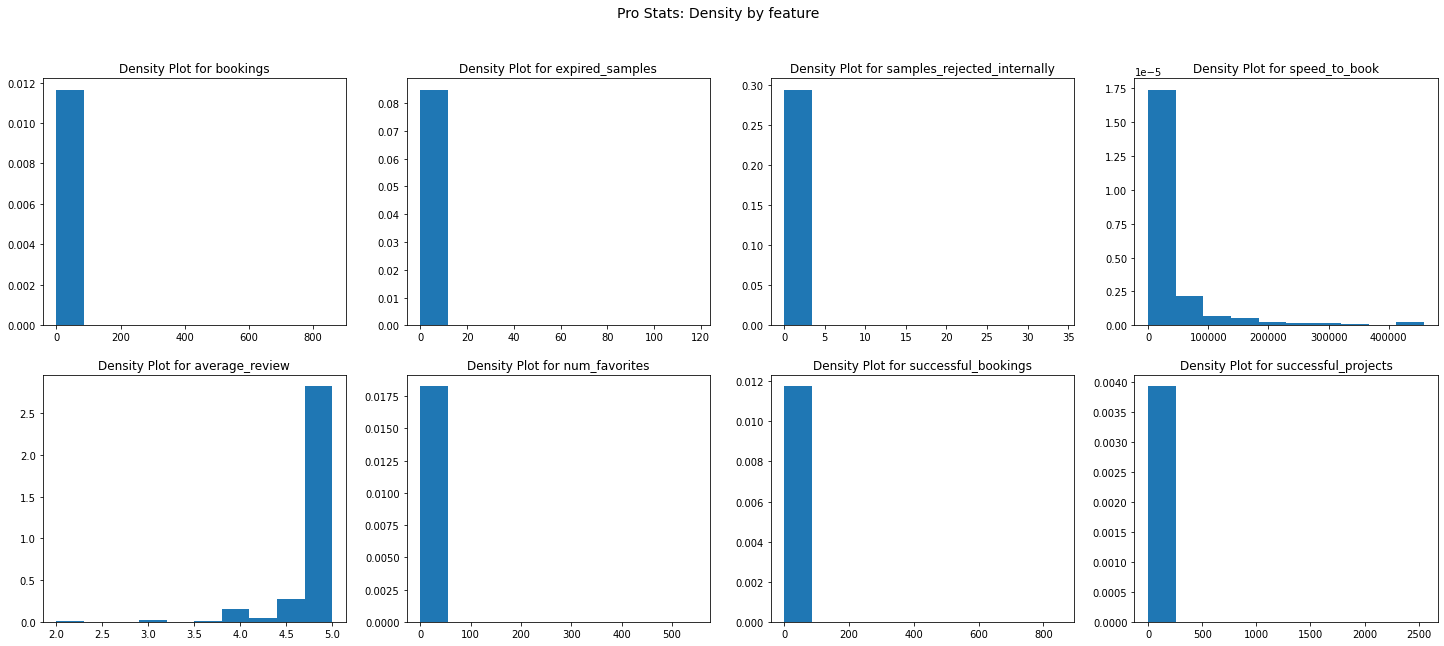

In [5]:
##lets look at all the histograms
columns_plot=pro_stats.drop(columns=['pro_id','category']).columns.values
fig = plt.figure(figsize=(25, 10))
for idx in np.arange(len(columns_plot)):
    ax = fig.add_subplot(2,4,idx+1)
    ax.hist(pro_stats[columns_plot[idx]],density=True)
    ax.set_title("Density Plot for {}".format(columns_plot[idx]))
    
fig.suptitle("Pro Stats: Density by feature",size=14);




### Generating a Score
For this test, and given that new users cannot be penalized heavily in order to allow them to be booked anytime, we'll generate a performance weighted score ranging from 0 to 100 using a standardized version of the variables to consider, such that a high value could indicate the following:

-  A Pro has proficiency to produce proper/good content (using number of samples rejected internally)
-  a Pro's popularity/quality of content (using average review) 
-  Quick response to the client (using speed to accept a booking) 


$ Performance Score=100*((1-Samples\ Rejected\ STD)*\alpha_{samples\ rejected} + Average\ Review\ STD*\alpha_{successful\ projects} + (1-Booking\ Speed\ STD) *\alpha_{Booking Speed})$

where $\alpha_i \in (0,1)$ and STD at the end of a variable indicates if has been scaled to have values from 0 to 1 using a MinMaxScaler

In [4]:
pro_stats.fillna(0,inplace=True)
columns_for_score=['samples_rejected_internally','speed_to_book','average_review']
scaled=MinMaxScaler().fit_transform(pro_stats[columns_for_score])

In [19]:
##lets compute the score and save the data, keeping original columns
pro_score=pd.DataFrame({'pro_id':pro_stats['pro_id'].values,'samples_rejected_internally':1-scaled[:,0],'speed_to_book':1-scaled[:,1],'average_review':scaled[:,2]})
pro_score.loc[:,'performance_score']=pro_score.apply(lambda d: 100*(WEIGHTS_SCORE['samples_rejected_internally']*d['samples_rejected_internally']+WEIGHTS_SCORE['speed_to_book']*d['speed_to_book']+ WEIGHTS_SCORE['average_review']*d['average_review']), axis=1)
pro_score=pro_score[['pro_id','performance_score']].merge(pro_stats.drop(columns="category"),on='pro_id',how="inner")
pro_score=pro_score[~pro_score.duplicated(subset="pro_id",keep='first')]
pro_score.to_pickle("pro_scores.pkl")
print("[INFO] No. Pros", pro_score.shape[0])
pro_score.head()

[INFO] No. Pros 102641


,pro_id,performance_score,bookings,expired_samples,samples_rejected_internally,speed_to_book,average_review,num_favorites,successful_bookings,successful_projects
0,A,40.0,0,0,0,0.0,0.0,0,0,0
1,E,40.0,0,0,0,0.0,0.0,0,0,0
2,13,40.0,0,0,0,0.0,0.0,0,0,0
3,18,40.0,0,0,0,0.0,0.0,0,0,0
12,1637D,40.0,0,0,0,0.0,0.0,0,0,0


### Final Remarks

- We've explored every dataset and also, generated some key features in order to use them later in the sample suggestion process. In the next notebook (02-Demo-sample finder.ipynb), we'll explore a possible solution to the test, using the data exported here.

- Pro's performance score does not work as it should given the amount of missing values for most of the stats, however, as pro's continue uploading samples and getting booked, this score should show their performance. Another way to improve this score would be using more features, but it's usage could penalize new pros even more. 